<a href="https://colab.research.google.com/github/shivendr7/ml/blob/GANs/Pix2pix_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
from tensorflow.keras.layers import Conv2D, Activation, LeakyReLU, Conv2DTranspose, BatchNormalization, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

In [2]:
def add_encoder(inputLayer, n_filters, batchnorm=True):
  init=RandomNormal(stddev=0.02)
  l1=Conv2D(filters=n_filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputLayer)
  if batchnorm:
    l1=BatchNormalization()(l1, training=True)
  lr=LeakyReLU(alpha=0.2)(l1)
  return lr

In [3]:
def add_decoder(inputLayer, skip_layer, n_filters, dropout=True):
  init=RandomNormal(stddev=0.02)
  l1=Conv2DTranspose(filters=n_filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputLayer)
  l2=BatchNormalization()(l1, training=True)
  if dropout:
    l2=Dropout(rate=0.5)(l2, training=True)
  l4=Concatenate()([l2, skip_layer])
  l3=Activation('relu')(l4)
  return l3

In [4]:
def build_generator(input_shape=(256, 256, 3)):
  in_image=Input(shape=input_shape)
  e1=add_encoder(in_image, 64, False)
  e2=add_encoder(e1, 128)
  e3=add_encoder(e2, 256)
  e4=add_encoder(e3, 512)
  e5=add_encoder(e4, 512)
  e6=add_encoder(e5, 512)
  e7=add_encoder(e6, 512)
  
  #bottleneck no batchnorm and relu
  init=RandomNormal(stddev=0.02)
  bott=Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)

  d1=add_decoder(bott, e7, 512)
  d2=add_decoder(d1, e6, 512)
  d3=add_decoder(d2, e5, 512)
  d4=add_decoder(d3, e4, 512)
  d5=add_decoder(d4, e3, 256, dropout=False)
  d6=add_decoder(d5, e2, 128, dropout=False)
  d7=add_decoder(d6, e1, 64, dropout=False)

  out_image=Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_layer=Activation('tanh')(out_image)

  model=Model(inputs=in_image, outputs=out_layer)
  return model

In [5]:
gen=build_generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [6]:
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file

In [7]:
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)

250249216/250242400 [==============================] - 92s 0us/step


In [8]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [9]:
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]; tar_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
  tar_list.append(pixels[:,256:])
src_list=np.asarray(src_list)
tar_list=np.asarray(tar_list)

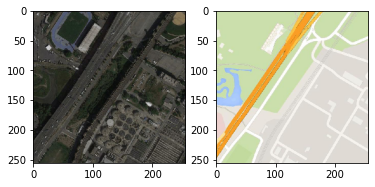

In [10]:
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(tar_list[0].astype('uint8'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


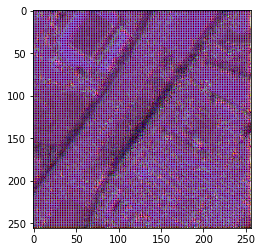

In [11]:
ar=gen.predict(src_list[0].reshape(1,256,256,3))
plt.imshow(ar.reshape(256,256,3))

In [12]:
from tensorflow.keras.optimizers import Adam

In [13]:
def build_discriminator(image_shape=(256,256,3)):
 init = RandomNormal(stddev=0.02)
  # source image input
 in_src_image = Input(shape=image_shape)
  # target image input
 in_target_image = Input(shape=image_shape)
  # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
	# C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
	# C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
	# C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
	# C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
	# patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
	# define model
 model = Model([in_src_image, in_target_image], patch_out)
	# compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 return model

In [ ]:
disc=build_discriminator()
out=disc.predict([src_list[0].reshape(1,256,256,3), tar_list[0].reshape(1,256,256,3)])
out[0]

In [15]:
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 6208        concatenate_7[0][0]        

In [39]:
def build_gan(gen, disc, img_shape=(256,256,3)):
  inp=Input(shape=(256,256,3))
  for layer in disc.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable=False
  gen_out=gen(inp)
  disc_out=disc([inp, gen_out])
  model=Model(inputs=inp, outputs=[disc_out, gen_out])
  opt=Adam(lr=0.002, beta_1=0.4)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  return model

In [21]:
src_list_mod=(src_list-127.5)/127.5
tar_list_mod=(tar_list-128.5)/127.5
len(src_list_mod), src_list_mod.shape

(1096, (1096, 256, 256, 3))

In [23]:
disc.output_shape, disc.output_shape[1]

((None, 16, 16, 1), 16)

In [26]:
from numpy.random import randint
val_temp=randint(0, 1096, 1)

In [29]:
def generate_real_samples(n_samples, patch_shape):
  ix=randint(0, src_list_mod.shape[0], n_samples)
  X1, X2=src_list_mod[ix], tar_list_mod[ix]
  #generate real class labels
  y=np.ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

In [30]:
def generate_fake_samples(gen, samples, patch_shape):
  X=gen.predict(samples)
  y=np.zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [42]:
def train(gen, disc, gan, n_epochs=2, n_batch=1):
  n_patch=disc.output_shape[1]
  for i in range(n_epochs):
    [XrealA, XrealB], y_real=generate_real_samples(1, n_patch)
    XfakeB, y_fake=generate_fake_samples(gen, XrealA, n_patch)
    d_loss1=disc.train_on_batch([XrealA, XrealB], y_real)
    d_loss2 = disc.train_on_batch([XrealA, XfakeB], y_fake)

    g_loss, _, _ = gan.train_on_batch(XrealA, [y_real, XrealB])
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

In [40]:
gan=build_gan(gen, disc)
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 256, 256, 3)  54429315    input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 16, 16, 1)    6968257     input_6[0][0]                    
                                                                 model[1][0]                      
Total params: 61,397,572
Trainable params: 54,422,275
Non-trainable params: 6,975,297
__________________________________________________________________________________________________


In [49]:
train(gen, disc, gan, n_epochs=20)

>1, d1[0.402] d2[0.437] g[8.189]
>2, d1[0.405] d2[0.413] g[6.980]
>3, d1[0.388] d2[0.390] g[14.012]
>4, d1[0.360] d2[0.441] g[15.459]
>5, d1[0.383] d2[0.452] g[16.782]
>6, d1[0.350] d2[0.436] g[9.328]
>7, d1[0.355] d2[0.415] g[23.448]
>8, d1[0.387] d2[0.401] g[8.374]
>9, d1[0.326] d2[0.407] g[12.441]
>10, d1[0.381] d2[0.423] g[7.914]
>11, d1[0.307] d2[0.318] g[27.176]
>12, d1[0.365] d2[0.393] g[10.241]
>13, d1[0.330] d2[0.339] g[18.253]
>14, d1[0.382] d2[0.419] g[9.627]
>15, d1[0.451] d2[0.373] g[7.536]
>16, d1[0.331] d2[0.300] g[17.233]
>17, d1[0.347] d2[0.358] g[12.341]
>18, d1[0.270] d2[0.368] g[7.458]
>19, d1[0.303] d2[0.326] g[7.960]
>20, d1[0.422] d2[0.372] g[18.015]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


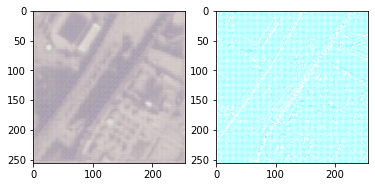

In [50]:
ar_out=gen.predict(src_list_mod[0].reshape(1,256,256,3))
ar_out2=gen.predict(src_list[0].reshape(1,256,256,3))
plt.subplot(1,2,1)
plt.imshow(ar_out.reshape(256,256,3))
plt.subplot(1,2,2)
plt.imshow(ar_out2.reshape(256,256,3))